In [1]:
# enables autoloading from updated functions in external libraries or scripts (to prevent complete )
%load_ext autoreload
%autoreload 2
# put plots in between cells
%matplotlib inline
# enable widgets from terminal (specified by !)
!jupyter nbextension enable --py widgetsnbextension

# import all necessary libraries

import os # folder and their item navigation and bookkeeping
import matplotlib.pyplot as plt # all things plotting
import sys # allows us to cue the notebook to look for external Python scripts 
from ipywidgets import interact, interactive, fixed, interact_manual # for interactive widgets
import ipywidgets as widgets
import itk # for image (tiff) loading
import numpy as np # manipulating array-like structures
import pickle # for saving data structures
import csv # for loading comma-delimited text files
import cv2 # for loading images and image processing
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset # for plot decoration
# allow lots of figures
plt.rcParams.update({'figure.max_open_warning': 0})
# the Python scripts added to the local path
sys.path.append(os.path.abspath(os.getcwd()+'/cmeAnalysisPostProcessingPythonScripts/'))
source_code = os.getcwd()+'/cmeAnalysisPostProcessingPythonScripts/'

# custom Python scripts for this analysis
from display_tracks import load_tracks
from nanopillar_detection import (hough_detection, 
                                  createLineIterator, 
                                  create_mask_from_hough_lines, 
                                  load_itk_image,
                                  test_on_pillar,
                                  format_image_hough_detection,
                                  return_puncta_relative_to_pillar,
                                  modify_filename,
                                  create_grid_display_nanopillars)
from display_tracks import (load_tracks, load_tracks_no_sort, display_tracks,
                            remove_tracks_by_criteria, 
                            select_tracks_by_indices,
                            remove_tracks_by_indices,

                            load_itk_image)
import return_track_attributes

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [284]:
#BF
file_20200312AP2siRNA_contsirna_cell_1_brightfield_nanopillar_50nm = \
'/Volumes/Backup Plus/150mOsm_50uMCK/120nm/26min/cell1_2s/MDA_dnm2GFP_AP2RFP_substr_post_2_005.nd2 - C=0 kept stack.tif'           


File being segmented: 
MDA_dnm2GFP_AP2RFP_substr_post_2_005.nd2 - C=0 kept stack.tif
the size of image is :(512, 512)


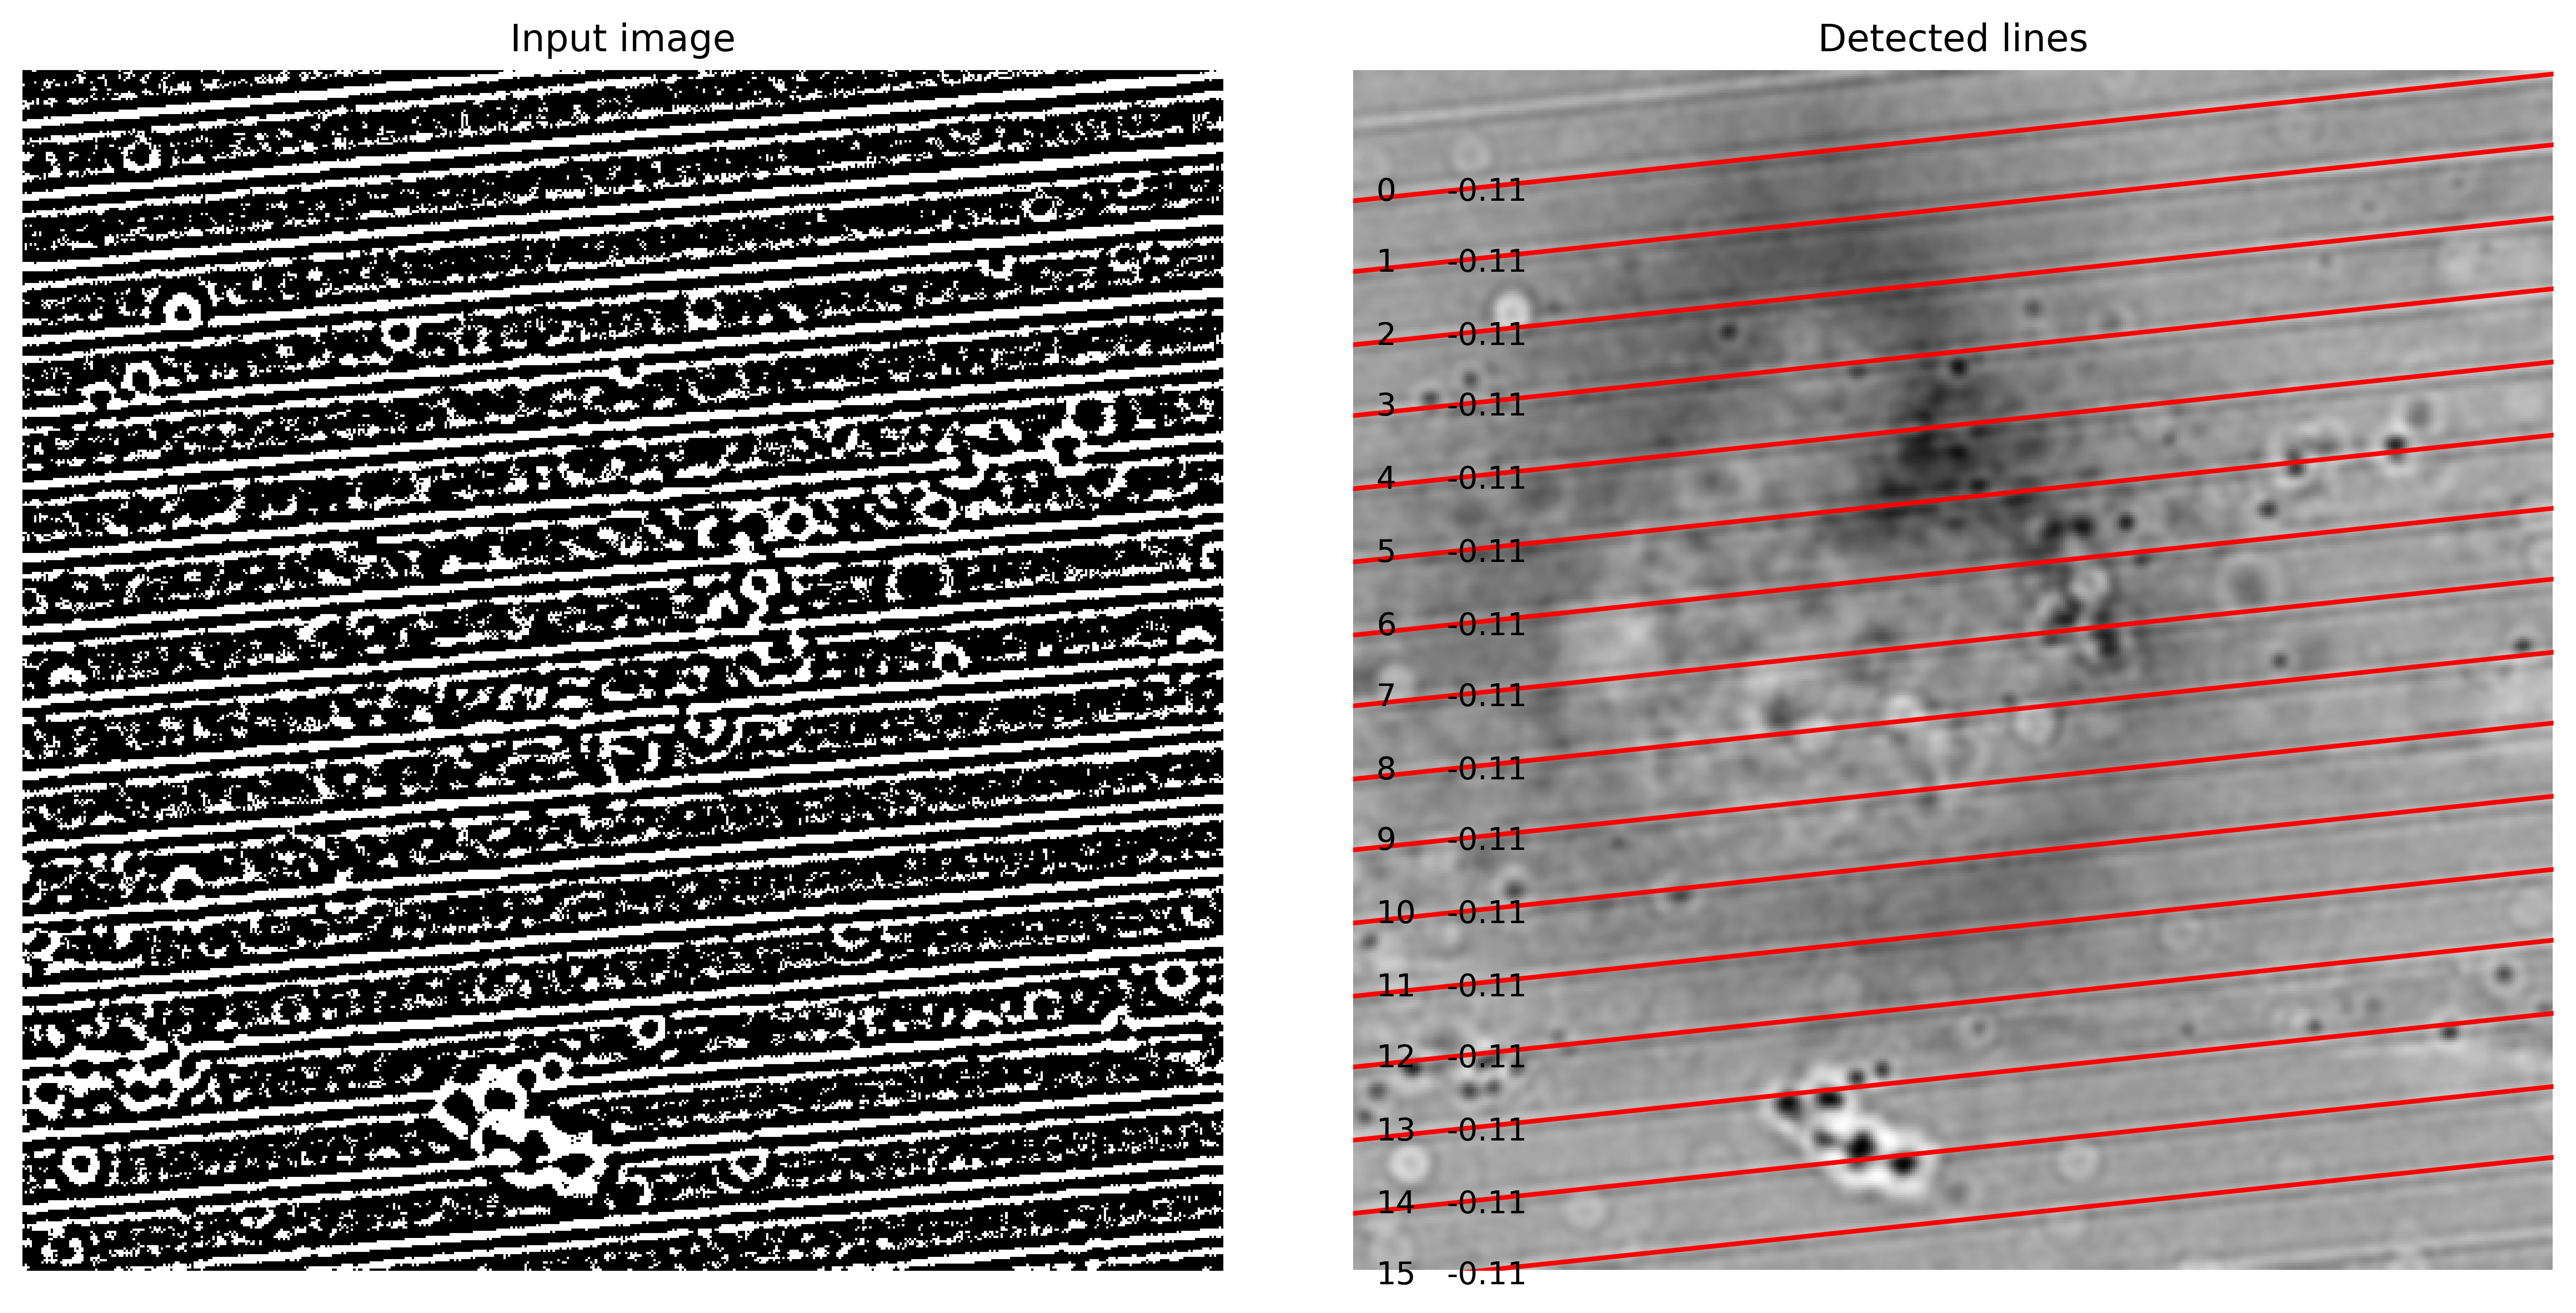

The slopes kept are: [-0.10569576 -0.10569576 -0.10569576 -0.10569576 -0.10569576 -0.10569576
 -0.10569576 -0.10569576 -0.10569576 -0.10569576 -0.10569576 -0.10569576
 -0.10569576 -0.10569576 -0.10569576 -0.10569576]
average slope: -0.1056957610003835
std of slopes: 4.4022346672339675e-17


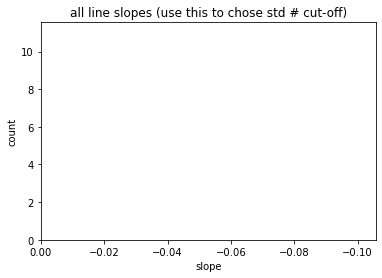

average of kept slopes: -0.1056957610003835


In [285]:
# for hough_detection(), provide:
# - the path to the brightfield image
# - the size of the Gaussian nxn kernel
# - the count of standard deviations away from the mean of predicted slopes to keep
# - True to show outputs (can be hidden)
# max_slope and min_slope can be used to reject false lines, but slopes are opposite of real world: neg slopes go up, pos slopes go down

y0s, y1s, slopes = hough_detection(file_20200312AP2siRNA_contsirna_cell_1_brightfield_nanopillar_50nm, 11, 1/2, True, max_slope=0.1, min_slope=-0.3)

In [70]:
#skip this if you don't need to excise extra lines, use list nomenclature to include only the valid detections
y0s = list(y0s)
y0s = y0s[15:18:] 
y0s = np.array(y0s)
y1s = list(y1s)
y1s = y1s[15:18:] 
y1s = np.array(y1s)

100%|██████████| 16/16 [00:00<00:00, 229.34it/s]

File being segmented: 
MDA_dnm2GFP_AP2RFP_substr_post_2_005.nd2 - C=0 kept stack.tif


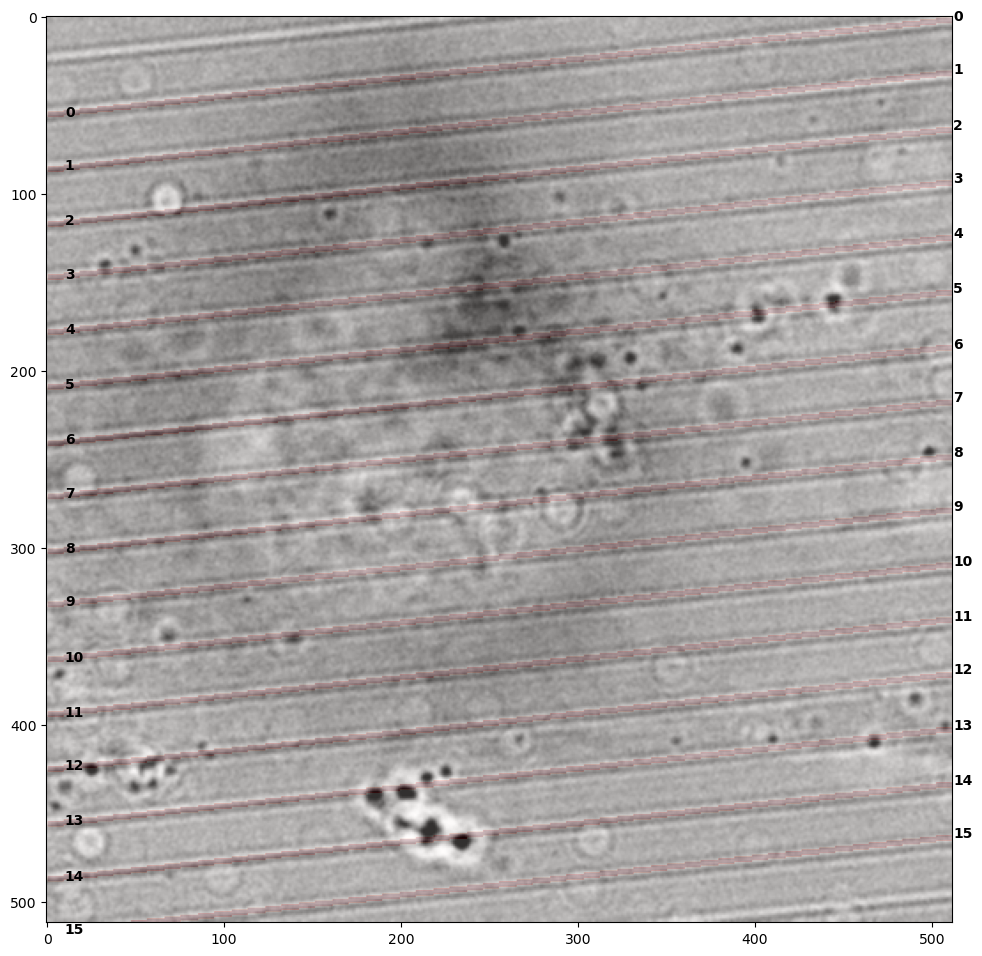

In [286]:
# make an initial prediction of the mask
# provide:
# - path to the brightfield 
# - y0s and y1s outputted by hough_detection()
# - the guess for the number of pixels to spread the line (it will occupy 2n+1 vertical pixels)
mask_control_cell_1 = create_mask_from_hough_lines(file_20200312AP2siRNA_contsirna_cell_1_brightfield_nanopillar_50nm,y0s,y1s,1)

In [289]:
# appending values to fill in missing mask positions at top and bottom of image
# y0s[2]-y0s[1]) is the guess for the distance separating stripes used to add stripes from the beginning and the end
# add to the top using ###[y0s[0]-i(y0s[2]-y0s[1])]### where i is an integer
# add to the bottom using ###[y0s[-1]+ i(y0s[-1]-y0s[-2])]###

y0s_updated_add_first = list(y0s) 
y1s_updated_add_first = list(y1s) 


In [291]:
# once values are added, let's ensure they are sorted in ascending order
y0s_updated_add_first.sort()
y1s_updated_add_first.sort()

In [292]:
# convert back to numpy arrays
y0s_updated_add_first=np.array(y0s_updated_add_first)
y1s_updated_add_first=np.array(y1s_updated_add_first)

In [293]:
# check manually for the new values added to the beginning and end
y0s_updated_add_first

array([ 55.84766633,  86.03559408, 117.22978609, 147.41771384,
       178.61190584, 209.80609785, 241.00028986, 271.1882176 ,
       302.38240961, 332.57033736, 363.76452937, 394.95872137,
       425.14664912, 456.34084113, 487.53503313, 517.72296088])

In [294]:
y1s_updated_add_first

array([  1.7314367 ,  31.91936445,  63.11355646,  93.3014842 ,
       124.49567621, 155.68986822, 186.88406022, 217.07198797,
       248.26617998, 278.45410773, 309.64829973, 340.84249174,
       371.03041949, 402.22461149, 433.4188035 , 463.60673125])

100%|██████████| 16/16 [00:00<00:00, 324.82it/s]

File being segmented: 
MDA_dnm2GFP_AP2RFP_substr_post_2_005.nd2 - C=0 kept stack.tif


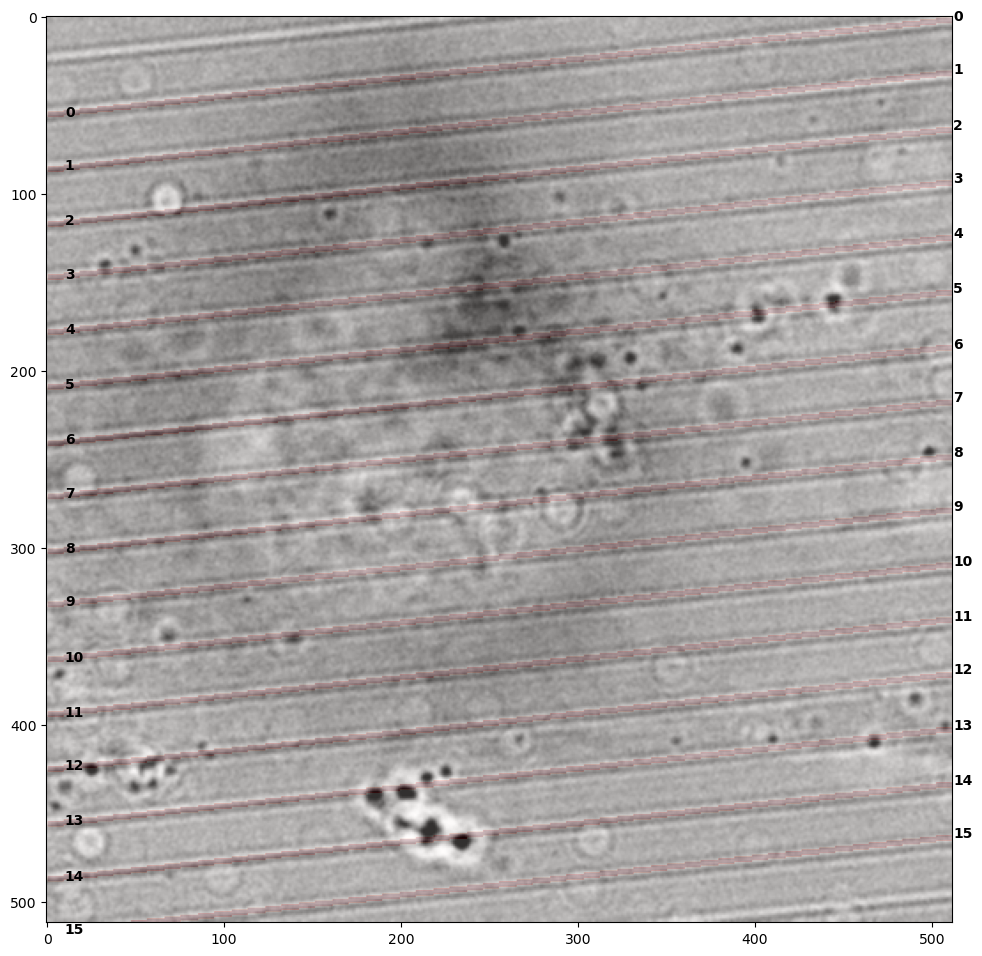

In [295]:
mask_cont_cell_5 = create_mask_from_hough_lines(file_20200312AP2siRNA_contsirna_cell_1_brightfield_nanopillar_50nm,y0s_updated_add_first,y1s_updated_add_first,1)

In [296]:
## adjust the endpoints so they match the image better
# store the first coordinate, put it back in a list, and add it to a list of modified end-points
y0s_updated_left_shifted =  [y0s_updated_add_first[0]-2] + \
                            [y0s_updated_add_first[1]-1] + \
                            [y0s_updated_add_first[2]-1] + \
                            [y0s_updated_add_first[3]-1] + \
                            [y0s_updated_add_first[4]-1] + \
                            [y0s_updated_add_first[5]-1] + \
                            [y0s_updated_add_first[6]-2] + \
                            [y0s_updated_add_first[7]-1] + \
                            [y0s_updated_add_first[8]-2] + \
                            [y0s_updated_add_first[9]-1] + \
                            [y0s_updated_add_first[10]-0] + \
                            [y0s_updated_add_first[11]-0] + \
                            [y0s_updated_add_first[12]-1] + \
                            [y0s_updated_add_first[13]-1] + \
                            [y0s_updated_add_first[14]-1] + \
                            [y0s_updated_add_first[15]-1] 
#                             [y0s_updated_add_first[16]-2] 
#                             [y0s_updated_add_first[17]-2] 
#                             [y0s_updated_add_first[18]+2] + \
#                             [y0s_updated_add_first[19]+2] + \
#                             [y0s_updated_add_first[20]+1] + \
#                             [y0s_updated_add_first[21]+1] + \
#                             [y0s_updated_add_first[22]+2] + \
#                             [y0s_updated_add_first[23]+2] 
#                             [y0s_updated_add_first[24]+3] 
#                             [y0s_updated_add_first[25]+1] + \
#                             [y0s_updated_add_first[26]-4] 
#                             [y0s_updated_add_first[27]-1]

In [297]:
# same thing for the right side but only some here and there need modification
y1s_updated_right_shifted = [y1s_updated_add_first[0]+0] + \
                            [y1s_updated_add_first[1]+1] + \
                            [y1s_updated_add_first[2]+0] + \
                            [y1s_updated_add_first[3]+1] + \
                            [y1s_updated_add_first[4]+0] + \
                            [y1s_updated_add_first[5]+0] + \
                            [y1s_updated_add_first[6]+0] + \
                            [y1s_updated_add_first[7]+0] + \
                            [y1s_updated_add_first[8]+0] + \
                            [y1s_updated_add_first[9]+0] + \
                            [y1s_updated_add_first[10]+1] + \
                            [y1s_updated_add_first[11]+0] + \
                            [y1s_updated_add_first[12]+0] + \
                            [y1s_updated_add_first[13]+0] + \
                            [y1s_updated_add_first[14]-1] + \
                            [y1s_updated_add_first[15]+1] 
#                             [y1s_updated_add_first[16]+0] 
#                             [y1s_updated_add_first[17]-0] 
#                             [y1s_updated_add_first[18]-2] + \
#                             [y1s_updated_add_first[19]-2] + \
#                             [y1s_updated_add_first[20]-2] + \
#                             [y1s_updated_add_first[21]-2] + \
#                             [y1s_updated_add_first[22]-2] + \
#                             [y1s_updated_add_first[23]+1] 
#                             [y1s_updated_add_first[24]-1] 
#                             [y1s_updated_add_first[25]+12] + \
#                             [y1s_updated_add_first[26]+12] 
                            #[y1s_updated_add_first[27]-2]

  0%|          | 0/16 [00:00<?, ?it/s]

File being segmented: 
MDA_dnm2GFP_AP2RFP_substr_post_2_005.nd2 - C=0 kept stack.tif


100%|██████████| 16/16 [00:00<00:00, 107.92it/s]


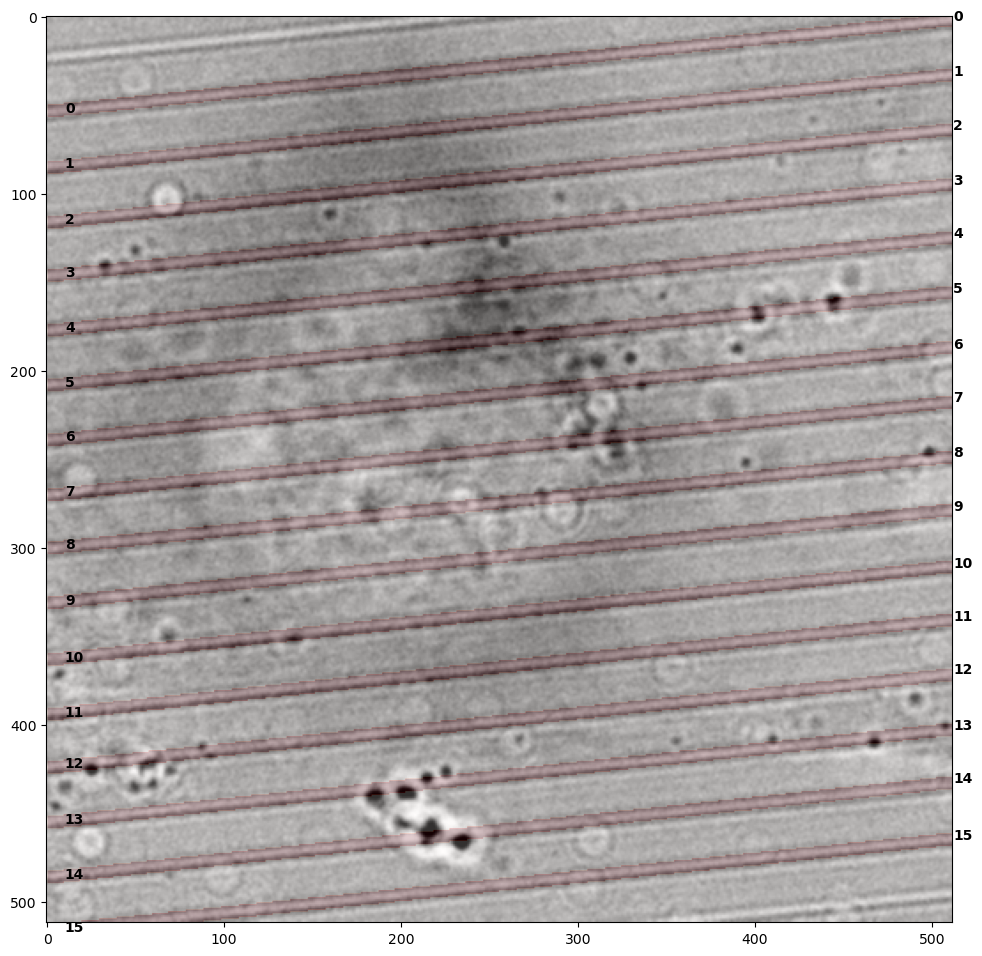

In [298]:
#now we make the mask
#widths: 2 for 75, 3 for 120, 4 for 200, 5 for 300, 7 for 500 

mask_file_20191108_cell_5_brightfield_nanopillar_50nm = create_mask_from_hough_lines(file_20200312AP2siRNA_contsirna_cell_1_brightfield_nanopillar_50nm,y0s_updated_left_shifted,y1s_updated_right_shifted,3)

In [299]:
### once we are happy (enough) with our mask product, we need to save it
new_file_name = modify_filename(file_20200312AP2siRNA_contsirna_cell_1_brightfield_nanopillar_50nm, 'mask_')

In [300]:
# the way I configured modify_filename() is that it takes the path to the brightfield and a prefix for the tiff file name
# and add the prefix to the tiff file and get rid of the file extension
new_file_name

'/Volumes/Backup Plus/150mOsm_50uMCK/120nm/26min/cell1_2s/mask_MDA_dnm2GFP_AP2RFP_substr_post_2_005'

In [301]:
# out final mask product is a numpy array, so we'll use np.save() to store it 
# we provide a filename and the array to save (https://numpy.org/doc/stable/reference/generated/numpy.save.html)
np.save(new_file_name, mask_file_20191108_cell_5_brightfield_nanopillar_50nm)